## Fetal immune dataset - metadata tables and plots 

In this notebook we collect and plot metadata for fetal immune dataset

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
%%R
remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}


In [5]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [6]:
new_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv'.format(t=timestamp))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Dataset stats

For manuscript

In [7]:
# def save_dataset_stats(new_obs, timestamp, data_dir="/nfs/team205/ed6/data/Fetal_immune/"):
dataset_stats = {}
dataset_stats['n_cells'] = new_obs.shape[0]
n_annotated_cells = new_obs[~new_obs.uniform_label.isna()].shape[0]
dataset_stats['perc_annotated_cells'] = n_annotated_cells/dataset_stats['n_cells']
dataset_stats['n_samples'] = new_obs.Sample.unique().shape[0]
dataset_stats['n_donors'] = new_obs.donor.unique().shape[0]
print(dataset_stats)

{'n_cells': 911873, 'perc_annotated_cells': 0.6645947407149899, 'n_samples': 221, 'n_donors': 25}


### Save metadata for samples 

In [59]:
sample_columns = ['file', 'organ', 'Sample.lanes', "Sort_id", "age", "method", "donor", 'Sample', 'sex']
n_cells = new_obs.groupby('file').count()[['Sample']]
n_unannotated = new_obs.groupby('file').apply(lambda x: x.isna().sum())[['uniform_label']]
sample_metadata = new_obs[sample_columns].drop_duplicates()
sample_metadata.index = sample_metadata.file.values

In [ ]:
sample_metadata['n_cells'] = n_cells['Sample']
sample_metadata['n_unannotated'] = n_unannotated['uniform_label']
sample_metadata['frac_unannotated'] = sample_metadata['n_unannotated']/sample_metadata['n_cells']

Text(0, 0.5, 'Fraction of unannotated cells')

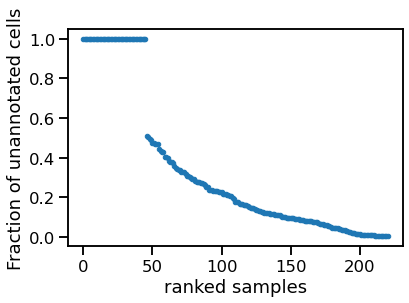

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
plt.plot(sample_metadata.sort_values('frac_unannotated', ascending=False)['frac_unannotated'].values, '.');
plt.xlabel("ranked samples"); plt.ylabel("Fraction of unannotated cells")

In [70]:
sample_metadata.to_csv(data_dir + 'PAN.A01.v01.{t}.sample_metadata.csv'.format(t=timestamp))

In [71]:
data_dir + 'PAN.A01.v01.{t}.sample_metadata.csv'.format(t=timestamp)

'/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.20210429.sample_metadata.csv'

### Clean VDJ metadata

In [104]:
vdj_meta = pd.read_csv(
    "/home/jovyan/mount/gdrive/Pan_fetal/meta_share/TCR_metadata_updated_20052021.csv", 
    index_col=0
    )

rename_columns = {
    'GEX_id':"file",
    'fetal_id':'donor',
    'sorting':'Sort_id'
}

rename_organ = {
    "liver":"LI",
    'spleen':"SP",
    'skin':"SK",
    'Prox_Ileum':'GU',
     'Prox_Ileum':"GU",
    'Mid_Ileum':"GU", 
    'Term_Ileum':"GU", 
    'Colon':'GU'
}

vdj_meta.columns = [rename_columns[x] if x in rename_columns.keys() else x for x in vdj_meta.columns]
vdj_meta.organ = [rename_organ[x] if x in rename_organ.keys() else x for x in vdj_meta.organ]

vdj_meta = pd.merge(vdj_meta, sample_metadata, how='left')
vdj_meta.to_csv(data_dir + 'PAN.A01.v01.{t}.VDJ_metadata.csv'.format(t=timestamp))

data_dir + 'PAN.A01.v01.{t}.VDJ_metadata.csv'.format(t=timestamp)

### Clean Visium metadata

In [120]:
visium_meta = pd.read_csv(
    "/home/jovyan/mount/gdrive/Pan_fetal/meta_share/p_fetal_visium_data_manifest - Sheet1.csv", 
    index_col=0
    )

In [122]:
rename_columns = {
    'GEX_id':"file",
    'Fetal_id':'donor',
    "Organ":'organ',
    'Age_PCW':"age"
}

rename_organ = {
    "LIV":"LI",
    'SPL':"SP",
    'THY':"TH",
    }

visium_meta.columns = [rename_columns[x] if x in rename_columns.keys() else x for x in visium_meta.columns]
visium_meta.organ = [rename_organ[x] if x in rename_organ.keys() else x for x in visium_meta.organ]
visium_meta['file'] = visium_meta.index

keep_metadata_cols = ['img_id', "EXP_id", "organ", "donor", "SN", "Visium_Area_id", "Date_sectioned", "Digestion time", "Data_dir", "file"]
visium_meta = visium_meta[keep_metadata_cols]

,img_id,EXP_id,organ,donor,SN,Visium_Area_id,Date_sectioned,Digestion time,Data_dir,file
Sanger_ID,,,,,,,,,,
WSSS_F_IMMsp9838712,F121_LP1_4LIV,LP1,LI,F121,V10U29-031,A1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838712
WSSS_F_IMMsp9838709,F117_LP1_1SPL,LP1,SP,F117,V10U29-031,D1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838709
WSSS_F_IMMsp9838710,F121_LP1_2SPL,LP1,SP,F121,V10U29-031,C1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838710
WSSS_F_IMMsp9838711,F121_LP1_3THY,LP1,TH,F121,V10U29-031,B1,NaN,24,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838711
WSSS_F_IMMsp9838717,F121_LP2_4LIV,LP2,LI,F121,V10U29-029,A1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838717
WSSS_F_IMMsp9838714,F117_LP2_1SPL,LP2,SP,F117,V10U29-029,D1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838714
WSSS_F_IMMsp9838715,F121_LP2_2SPL,LP2,SP,F121,V10U29-029,C1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838715
WSSS_F_IMMsp9838716,F121_LP2_3THY,LP2,TH,F121,V10U29-029,B1,NaN,24,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp9838716
WSSS_F_IMMsp10864177,F113_LP3_1SPL,LP3,SP,F113,V10U29-028,D1,NaN,18,/nfs/team205/ig7/work_backups/backup_210306/pr...,WSSS_F_IMMsp10864177


In [123]:
visium_meta.to_csv(data_dir + 'PAN.A01.v01.{t}.visium_metadata.csv'.format(t=timestamp))
data_dir + 'PAN.A01.v01.{t}.visium_metadata.csv'.format(t=timestamp)

'/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.20210429.visium_metadata.csv'

### Plot previous annotations

Harmonized in `src/1_PFI_merging/20201230_uniform_annotations.ipynb`

In [6]:
df = new_obs[['uniform_label_lvl0', "uniform_label_expanded_merged","Sample", 'organ']].groupby(["uniform_label_lvl0","uniform_label_expanded_merged","organ"]).count() \
    .unstack(fill_value=0).stack().reset_index()

'organ'

In [7]:
%%R -i df -w 1000 -h 1300
library(patchwork)

p1 <- df %>% 
rename(count=Sample) %>%
ggplot(aes(uniform_label_expanded_merged, count, fill=organ)) +
geom_col(position="fill") +
# scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
ylab("fraction") +
theme(strip.background = element_blank(),
  strip.text.y = element_blank()) 

p2 <- df %>%
rename(count=Sample) %>%
group_by(uniform_label_expanded_merged, uniform_label_lvl0) %>%
summarise(tot_count=sum(count)) %>%
ggplot(aes(uniform_label_expanded_merged, tot_count)) +
geom_col() +
scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
theme(strip.text.y=element_text(angle=0), axis.text.y=element_blank(),
     axis.ticks.y=element_blank(), axis.title.y=element_blank()) 

`summarise()` has grouped output by 'uniform_label_expanded_merged'. You can override using the `.groups` argument.


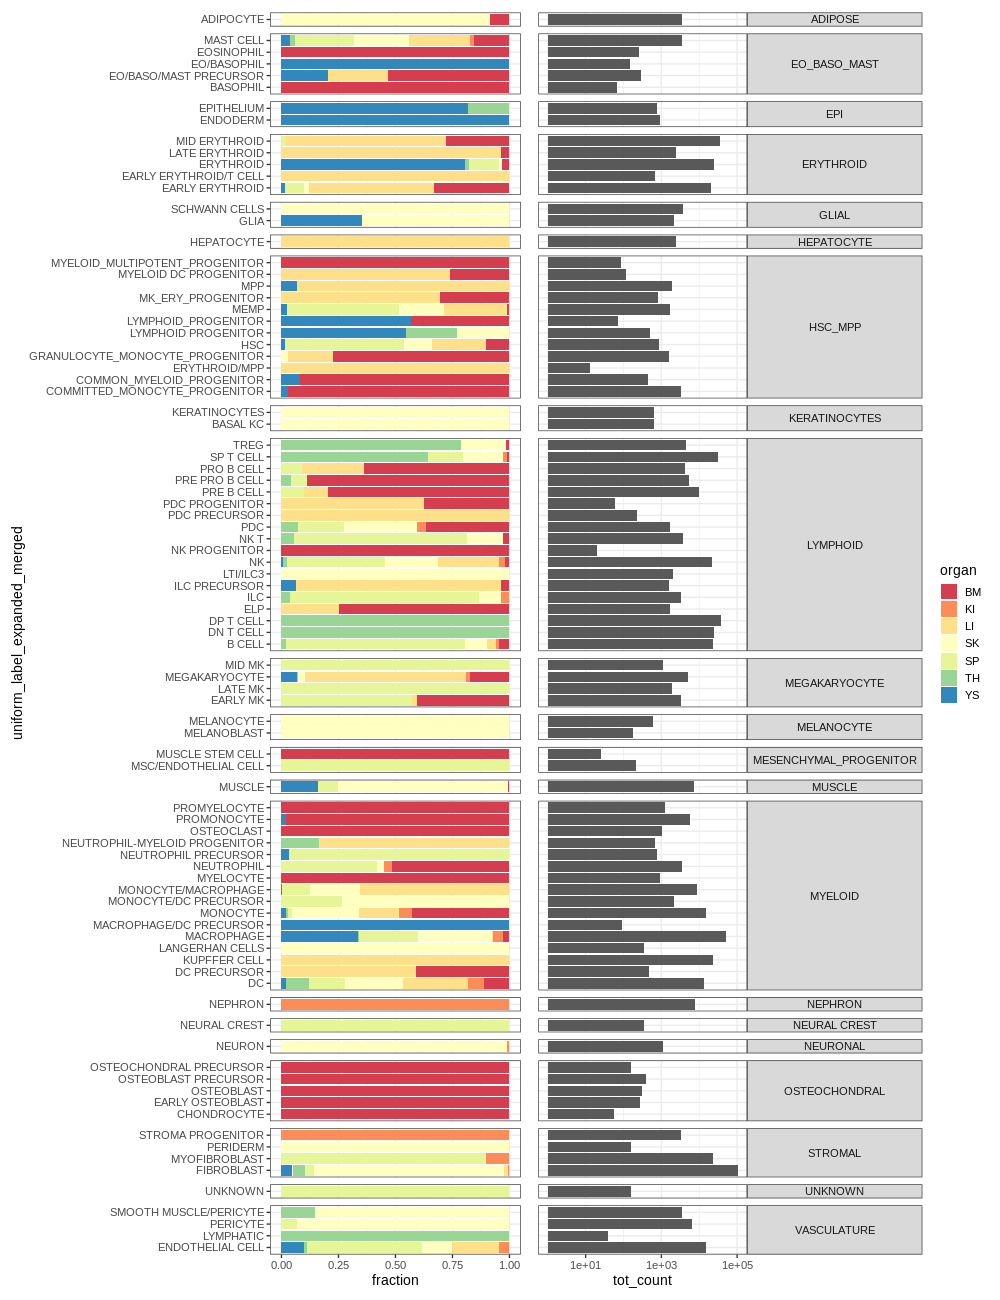

In [8]:
%%R -w 1000 -h 1300
p1 + p2 +
plot_layout(guides="collect", widths=c(1.2,1)) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.pdf", width=14, height=16) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.png", width=14, height=16)

### Plot donor VS organs

In [76]:
donor_count = new_obs.reset_index()[["organ", "donor", "index"]].groupby(["donor", "organ"]).count().reset_index()


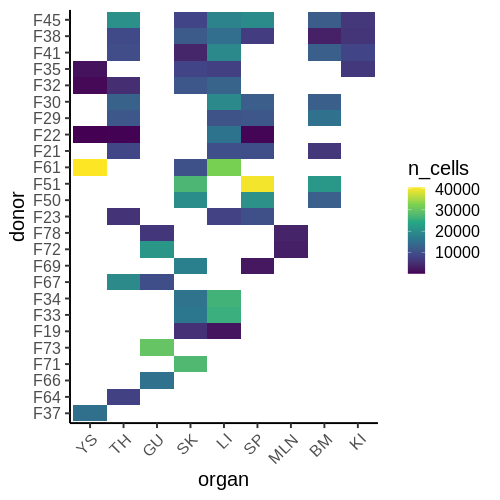

In [11]:
%%R -i donor_count -w 500 -h 500

donor_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(organ, donor, fill=n_cells)) +
geom_tile() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
scale_fill_viridis_c() +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.pdf", width=7, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.png", width=7, height=8)

In [83]:
method_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index", "method"]].groupby(["Sample", "donor", "organ", 'age', 'method']).count().reset_index()


In [84]:
method_count

,Sample,donor,organ,age,method,index
0,F19_LI_CD45N_FCAImmP7241243,F19,LI,10,3GEX,147
1,F19_LI_CD45P_FCAImmP7241242,F19,LI,10,3GEX,1719
2,F19_SK_CD45N_FCAImmP7241241,F19,SK,10,3GEX,5076
3,F19_SK_CD45P_FCAImmP7241240,F19,SK,10,3GEX,379
4,F21_BM_CD45N_FCAImmP7179368,F21,BM,16,3GEX,2383
...,...,...,...,...,...,...
216,F78_GU_CD45P_CD45N_FCA_gut8015057,F78,GU,17,5GEX,777
217,F78_GU_CD45P_CD45N_FCA_gut8015058,F78,GU,17,5GEX,1854
218,F78_GU_CD45P_CD45N_FCA_gut8015059,F78,GU,17,5GEX,1552
219,F78_GU_CD45P_CD45N_FCA_gut8015060,F78,GU,17,5GEX,1918


In [103]:
import numpy as np
import matplotlib.pyplot as plt


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

method_colors = colors[:2]
method_colors

['#1f77b4', '#ff7f0e']

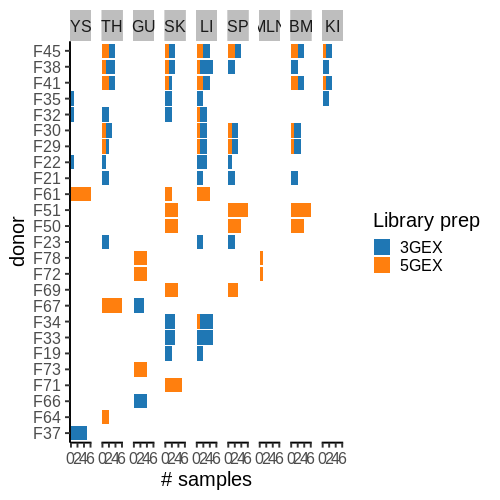

In [107]:
%%R -i method_count -i method_colors -w 500 -h 500

method_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=length(unique(organ)), n_samples=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, fill=method)) +
geom_bar() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
facet_grid(.~organ) +
    theme_classic(base_size=20) +
    scale_color_brewer(palette="Spectral") +
    guides(color="none") +
    scale_size(range=c(5,10), name="# cells") +
    coord_flip() +
    ylab("# samples") +
    scale_fill_manual(name="Library prep", values=method_colors) +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
#         axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
    ) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_method_plot.pdf", width=10, height=6) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_method_plot.png", width=10, height=6)

### Plot organ VS age

In [108]:
age_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index", "method"]].groupby(["Sample", "donor", "organ", 'age', 'method']).count().reset_index()


`summarise()` has grouped output by 'organ', 'age'. You can override using the `.groups` argument.


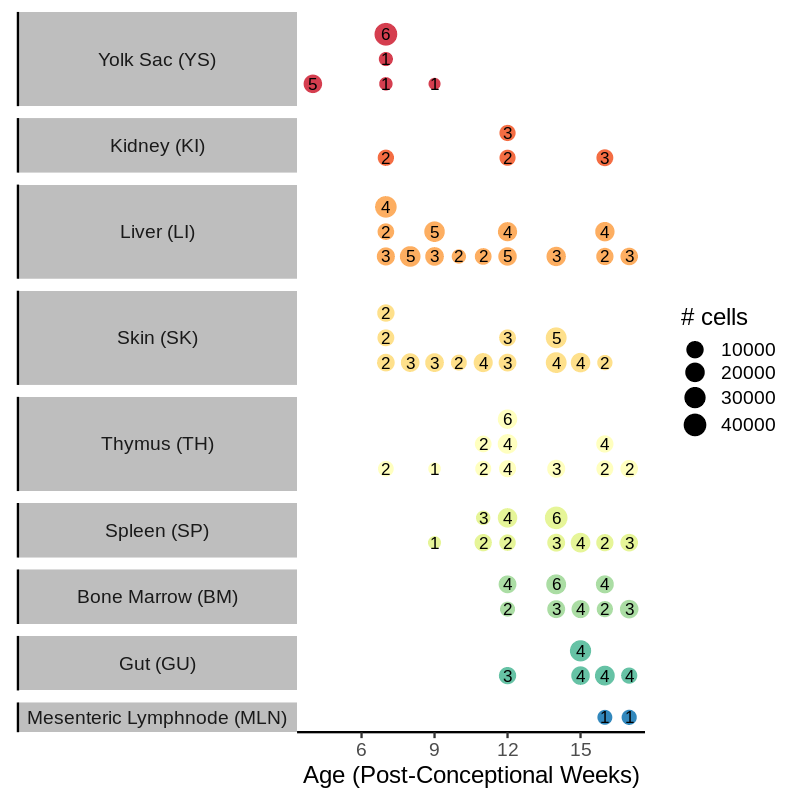

In [109]:
%%R -i age_count -w 800 -h 800

organ_labeller <- c(
    BM="Bone Marrow (BM)",
    GU="Gut (GU)",
    KI="Kidney (KI)",
    LI="Liver (LI)",
    MLN="Mesenteric Lymphnode (MLN)",
    SK="Skin (SK)",
    SP="Spleen (SP)",
    TH="Thymus (TH)",
    YS="Yolk Sac (YS)"
)

pl <- age_count %>%
    rename(n_cells=index) %>%
    arrange(age, donor, organ) %>%
    mutate(donor = factor(donor, levels=unique(donor))) %>%
    mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
    # mutate(organ = factor(organ, levels=unique(organ))) %>%
    group_by(organ, age, donor) %>%
    summarise(n_samples=n(), n_cells=sum(n_cells)) %>%
    group_by(organ, age) %>%
    mutate(rank_donor=row_number()) %>%
    mutate(organ=organ_labeller[organ]) %>%
    group_by(organ) %>%
    mutate(min_age=min(age)) %>%
    ungroup() %>%
    arrange(min_age) %>%
    mutate(organ=factor(organ, levels=unique(organ))) %>%
    ggplot(aes(age, rank_donor, color=organ)) +
    geom_point(aes(size=n_cells)) +
    geom_text(aes(label=n_samples), color="black", size=6) +
    # geom_tile(color='black') +
    scale_y_continuous(expand=c(0.3,0.3)) +
    xlab("Age (Post-Conceptional Weeks)") +
    theme_classic(base_size=24) +
    scale_color_brewer(palette="Spectral") +
    guides(color="none") +
    facet_grid(organ~., scales="free", space="free", switch="both") +
    scale_size(range=c(5,10), name="# cells") +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()
    ) 



pl +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.pdf", width=12, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.png", width=12, height=8) 





### Plot with TCR/BCR/Visium info

In [8]:
## Load metadata on immune receptor data
abTCR_meta = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/TCR_metadata_updated_20052021.csv", index_col=0)
gdTCR_meta = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/gdTCR_metadata_02082021.csv", index_col=0)
BCR_meta = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/BCR_metadata_updated_20052021.csv", index_col=0)

In [90]:
## Load metadata on Visium
visium_meta = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/p_fetal_visium_data_manifest - Sheet1.csv", index_col=0, header=None)
# visium_meta.columns = ['visium_sample_id', "organ", "donor"]
visium_meta
# visium_meta.organ = [x[:2] for x in visium_meta.organ]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,
Sanger_ID,img_id,EXP_id,Organ,Fetal_id,SN,Visium_Area_id,Age_PCW,Date_sectioned,seq?,Status,SapceRanger?,nBlocks,Block_ID,Digestion time,Repeats,Notes,Data_dir
WSSS_F_IMMsp9838712,F121_LP1_4LIV,LP1,LIV,F121,V10U29-031,A1,18,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838709,F117_LP1_1SPL,LP1,SPL,F117,V10U29-031,D1,11,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838710,F121_LP1_2SPL,LP1,SPL,F121,V10U29-031,C1,18,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838711,F121_LP1_3THY,LP1,THY,F121,V10U29-031,B1,18,NaN,T,Complete,T,NaN,NaN,24,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838717,F121_LP2_4LIV,LP2,LIV,F121,V10U29-029,A1,18,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838714,F117_LP2_1SPL,LP2,SPL,F117,V10U29-029,D1,11,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838715,F121_LP2_2SPL,LP2,SPL,F121,V10U29-029,C1,18,NaN,T,Complete,T,NaN,NaN,18,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...
WSSS_F_IMMsp9838716,F121_LP2_3THY,LP2,THY,F121,V10U29-029,B1,18,NaN,T,Complete,T,NaN,NaN,24,NaN,NaN,/nfs/team205/ig7/work_backups/backup_210306/pr...


In [9]:
has_abTCR = abTCR_meta["GEX_id"]
has_gdTCR = gdTCR_meta["GEX file"]
has_BCR = BCR_meta["GEX file"]

new_obs["has_abTCR"] = new_obs["Sample.lanes"].isin(has_abTCR)
new_obs["has_gdTCR"] = new_obs["Sample.lanes"].isin(has_gdTCR)
new_obs["has_BCR"] = new_obs["Sample.lanes"].isin(has_BCR)

In [12]:
# sample_cols = ["donor", "organ", 'has_abTCR', 'age', "method", "has_gdTCR", "has_BCR", "Sample.lanes", 'sex']
sample_cols = ["donor", "organ", 'has_abTCR', 'age', "has_gdTCR", "has_BCR",'sex']

sample_obs = new_obs[sample_cols +['index']]
sample_obs.loc[sample_obs.donor=="F78", "sex"] = "male"
sample_obs.loc[sample_obs.donor=="F72", "sex"] = "female"
# sample_obs["sex"] = [x if np.isnan(x) else 'unknown' for x in sample_obs['sex']]
sample_obs = sample_obs.groupby(sample_cols).count().reset_index()
sample_obs.columns = sample_cols + ['n_cells']
sample_obs

,donor,organ,has_abTCR,age,has_gdTCR,has_BCR,sex,n_cells
0,F19,LI,False,10,False,False,female,1866
1,F19,SK,False,10,False,False,female,5455
2,F21,BM,False,16,False,False,male,6161
3,F21,LI,False,16,False,False,male,9772
4,F21,SP,False,16,False,False,male,9664
...,...,...,...,...,...,...,...,...
116,F72,GU,True,16,False,True,female,21297
117,F72,MLN,True,16,False,True,female,2979
118,F73,GU,True,15,False,True,female,29849
119,F78,GU,True,17,False,True,male,6101


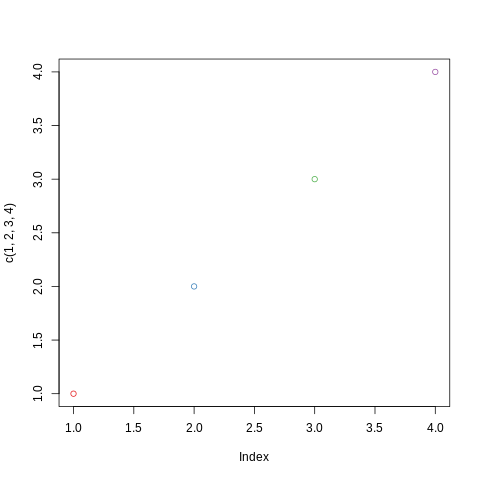

In [93]:
%%R
plot(c(1,2,3,4), col=tech_colors)

`summarise()` has grouped output by 'donor', 'age', 'sex'. You can override using the `.groups` argument.


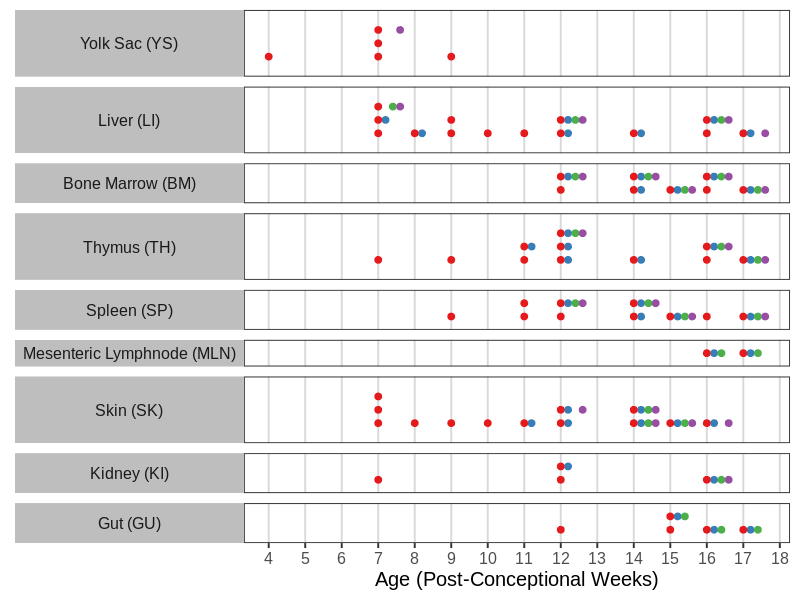

In [49]:
%%R -i sample_obs -w 800 -h 600
tech_colors <- RColorBrewer::brewer.pal(4, "Set1")
        
organ_labeller <- c(
    YS="Yolk Sac (YS)",
    LI="Liver (LI)",
    BM="Bone Marrow (BM)",
    TH="Thymus (TH)",
    SP="Spleen (SP)",
    MLN="Mesenteric Lymphnode (MLN)",
    SK="Skin (SK)",
    KI="Kidney (KI)",
    GU="Gut (GU)"
)

pl1 <-  
sample_obs %>%
    group_by(donor, age, sex, organ) %>%
    summarise(has_abTCR = any(has_abTCR), has_gdTCR = any(has_gdTCR), has_BCR = any(has_BCR),
              n_cells=sum(n_cells)
             ) %>%
    ungroup() %>%
    arrange(age, donor, organ) %>%
    mutate(donor = factor(donor, levels=unique(donor))) %>%
#     mutate(Sample = factor(Sample.lanes, levels=unique(Sample.lanes))) %>%
    # mutate(organ = factor(organ, levels=unique(organ))) %>%
#     group_by(organ, age, donor) %>%
#     summarise(n_samples=n(), n_cells=sum(n_cells)) %>%
    group_by(donor) %>%
    mutate(n_techs = sum(has_abTCR, has_BCR, has_gdTCR)) %>%
    ungroup() %>%
    arrange(n_techs) %>%
    group_by(organ, age) %>%
    arrange(n_techs) %>%
    mutate(rank_donor=row_number()) %>%
    mutate(organ=organ_labeller[organ]) %>%
    mutate(organ=factor(organ, levels=organ_labeller)) %>%
    ggplot(aes(age, rank_donor)) +
    geom_point(data=. %>% filter(has_abTCR), aes(age + 0.2), size=3, color=tech_colors[2]) +
    geom_point(data=. %>% filter(has_BCR), aes(age + 0.4), size=3, color=tech_colors[3]) +
    geom_point(data=. %>% filter(has_gdTCR), aes(age + 0.6), size=3, color=tech_colors[4]) +
    geom_point(color=tech_colors[1], size=3) +
#     geom_point(data=visium_meta, aes(y=0), size=10, shape=10) +
    scale_y_continuous(expand=c(0.5,0.5)) +
    scale_x_continuous(breaks=seq(4,18)) +
#     scale_shape_manual(values=c('5GEX'=15, '3GEX'=19)) +
    xlab("Age (Post-Conceptional Weeks)") +
    theme_bw(base_size=20) +
    facet_grid(organ~., scales="free", space="free", switch="both") +
    scale_size(range=c(5,10), name="# cells") +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
        axis.line.y=element_blank(),
        panel.grid.major.x=element_line(color='grey85'),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
        panel.grid=element_blank()
    ) 



pl1  +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_tech_plot.pdf", width=10.5, height=6) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_tech_plot.png", width=10.5, height=6) 


pl1

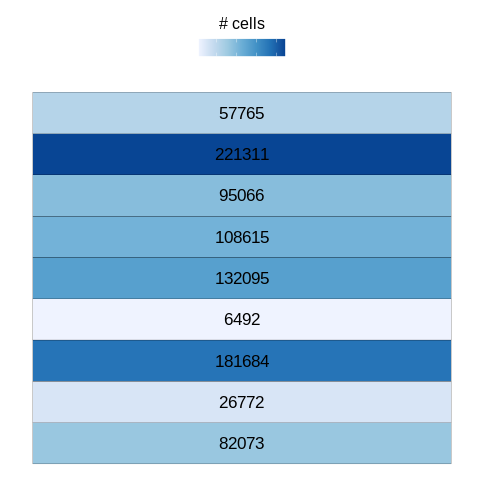

In [85]:
%%R
pl2 <- sample_obs %>%
   arrange(age, donor, organ) %>%
    mutate(donor = factor(donor, levels=unique(donor))) %>%
    mutate(organ=organ_labeller[organ]) %>%
    mutate(organ=factor(organ, levels=rev(organ_labeller))) %>%
group_by(organ) %>%
summarise(n_cells=sum(n_cells)) %>%
ggplot(aes(organ, 1, fill=n_cells)) +
geom_tile(color='black') +
geom_text(aes(label=n_cells), size=6) +
scale_fill_distiller(palette = "Blues", direction=1, name="# cells", labels=c()) +
guides(fill=guide_colorbar(title.hjust=0.5, title.position='top')) +
# scale_y_continuous(expand=c(0,)) +
coord_flip() +
ylab("# cells") +
theme_classic(base_size=16) +
remove_x_axis() +
remove_y_axis() +
theme(legend.position='top', axis.line=element_blank())

pl2 +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ncells_organ_plot.pdf", width=4, height=11) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ncells_organ_plot.png", width=4, height=11) 



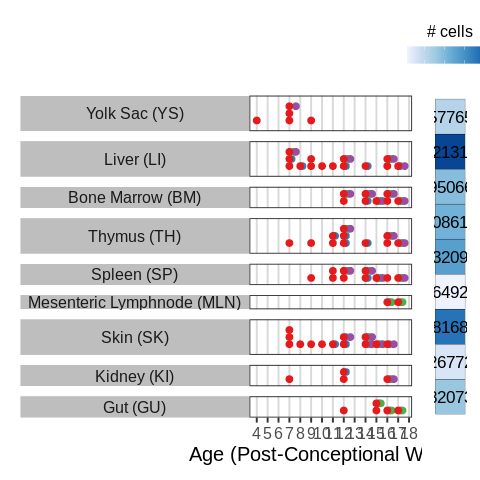

In [87]:
%%R
library(patchwork)
(pl1 | pl2) + plot_layout(widths=c(10,2)) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_tech_plot_wNcells.pdf", width=12, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_tech_plot_wNcells.png", width=12, height=8) 


### Save color palette 4 organs

In [162]:
import seaborn as sns
import matplotlib
cmap = matplotlib.cm.get_cmap('tab10', 9)

cmap = sns.color_palette("colorblind", 9)

In [163]:
colors = [matplotlib.colors.rgb2hex(x) for x in cmap]

In [164]:
col_df = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)
org_order = ["YS", "LI", "BM", "TH", "SP", "MLN", 'SK',"GU", "KI"]
col_df.index = col_df["organ"]
col_df = col_df.loc[org_order]

In [165]:
col_df["color"] = colors

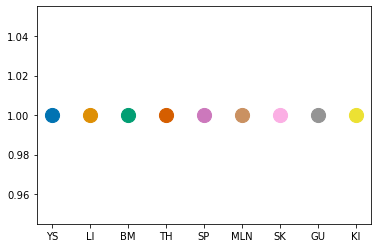

In [167]:
for i in range(col_df.shape[0]):
    matplotlib.pyplot.scatter(col_df["organ"][i], 1,  s=200, color=col_df["color"][i])

In [169]:
col_df.to_csv("../../metadata/organ_colors.csv")